In [1]:
# import the necessary packages
from facebook_scraper import get_posts
from twitter_scraper import get_tweets
from textblob import TextBlob
import seaborn as sns
import pandas as pd
import numpy as np
import time
import json
import re

from AttributeRelevance import *
from Features import *

# Part - 1: Data Collection

## Scrape facebook

In [2]:
# define a function to scrape facebook posts
def scrape_facebook(accounts):
    posts = []
    count = 0
    for account in accounts:
        for post in get_posts(account):
            try:
                post_dict = {}
                post_dict["post_id"] = post["post_id"]
                post_dict["text"] = post["text"]
                post_dict["post_text"] = post["post_text"]
                post_dict["shared_text"] = post["shared_text"]
                post_dict["time"] = post["time"]
                post_dict["image"] = post["image"]
                post_dict["video"] = post["video"]
                post_dict["video_thumbnail"] = post["video_thumbnail"]
                post_dict["video_id"] = post["video_id"]
                post_dict["likes"] = post["likes"]
                post_dict["comments"] = post["comments"]
                post_dict["shares"] = post["shares"]
                post_dict["post_url"] = post["post_url"]
                post_dict["link"] = post["link"]
                post_dict["user_id"] = post["user_id"]
                post_dict["images"] = post["images"]
                posts.append(post_dict)
            except:
                continue
        count += 1
        print(f"complete scrapping {count} accounts out of {len(accounts)} accounts")
            
    return posts

In [3]:
# facebook pages to be scrape which are related to SRH and GBV
facebook_accounts = ["SRHMJournal", "FSRH.UK", "mmsa.scora", "BMJ.SRH", 
                     "BLreproductivehealth", "actioncanadaSHR", "GBVPrevNetwork", 
                     "StopGBVatWork", "16DaysCampaign", "SayNO.UNiTE", "TheYellowMovementAau"]

# scrape facebook posts related to SRH and GBV
start = time.time()
posts = scrape_facebook(facebook_accounts)
end = time.time()
print(f"data scraping takes: {(end - start)} seconds")
fb_posts_df = pd.DataFrame(posts)
fb_posts_df.shape

complete scrapping 1 accounts out of 11 accounts
complete scrapping 2 accounts out of 11 accounts
complete scrapping 3 accounts out of 11 accounts
complete scrapping 4 accounts out of 11 accounts
complete scrapping 5 accounts out of 11 accounts
complete scrapping 6 accounts out of 11 accounts
complete scrapping 7 accounts out of 11 accounts
complete scrapping 8 accounts out of 11 accounts
complete scrapping 9 accounts out of 11 accounts
complete scrapping 10 accounts out of 11 accounts
complete scrapping 11 accounts out of 11 accounts
data scraping takes: 1020.8554711341858 seconds
            post_id                                               text  \
0  4183582811698940  New research finds that by using #photovoice, ...   
1  4181041485286406  We cannot overlook #reprohealth and #reprorigh...   
2  4179768305413724  Our latest editorial is now available online. ...   
3  4178431158880772  Evidence of the #health system challenges to p...   
4  4176874072369814  President Biden repe

In [4]:
AWAREsg_df = pd.read_csv("../data/AWAREsg.csv")
AWAREsg_df.shape

(38, 16)

In [5]:
emerge_global_df = pd.read_csv("../data/EmergeGlobal.csv")
emerge_global_df = emerge_global_df.drop(columns=["Unnamed: 16", "Unnamed: 17"])
emerge_global_df.shape

(38, 16)

In [6]:
equality_now_df = pd.read_csv("../data/equalitynow.csv")
equality_now_df.shape

(38, 16)

In [7]:
girls_are_not_for_sale_df = pd.read_csv("../data/girlsarenotforsale.csv")
girls_are_not_for_sale_df.shape

(26, 16)

In [130]:
# concatinating the scrapped dataframes
frames = [fb_posts_df, AWAREsg_df, emerge_global_df, equality_now_df, girls_are_not_for_sale_df]
df = pd.concat(frames)
df.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,likes,comments,shares,post_url,link,user_id,images
0,4183582811698940,"New research finds that by using #photovoice, ...","New research finds that by using #photovoice, ...",,2021-02-04 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,None,None,None,2.0,0.0,0,None,https://bit.ly/2XZFJyV,126697227387539,[https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0...
1,4181041485286406,We cannot overlook #reprohealth and #reprorigh...,We cannot overlook #reprohealth and #reprorigh...,SRHM.ORG\nCall for Papers: COVID-19,2021-02-03 13:25:03,None,None,None,None,3.0,0.0,0,https://facebook.com/story.php?story_fbid=4181...,http://www.srhm.org/call-for-papers-covid19/,126697227387539,[]
2,4179768305413724,Our latest editorial is now available online. ...,Our latest editorial is now available online. ...,TANDFONLINE.COM\nA round-up of articles in 2020,2021-02-03 00:41:05,None,None,None,None,0.0,0.0,0,https://facebook.com/story.php?story_fbid=4179...,https://bit.ly/3oDquXj,126697227387539,[]
3,4178431158880772,Evidence of the #health system challenges to p...,Evidence of the #health system challenges to p...,,2021-02-02 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,None,None,None,3.0,0.0,0,None,https://bit.ly/3qC86PZ,126697227387539,[https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0...
4,4176874072369814,President Biden repeals the Global Gag Rule - ...,President Biden repeals the Global Gag Rule - ...,,2021-02-01 21:48:36,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,None,None,None,1.0,0.0,0,None,https://mailchi.mp/c0533878aec1/your-april-new...,126697227387539,[https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0...


In [131]:
df.shape

(564, 16)

In [4]:
df.to_csv('../data/fb_posts.csv', index=False)

In [2]:
df = pd.read_csv('../data/fb_posts.csv')
df.shape

(564, 16)

In [3]:
df.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,likes,comments,shares,post_url,link,user_id,images
0,4.183583e+15,"New research finds that by using #photovoice, ...","New research finds that by using #photovoice, ...",NaN,2021-02-04 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,2.0,0.0,0,NaN,https://bit.ly/2XZFJyV,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....
1,4.181041e+15,We cannot overlook #reprohealth and #reprorigh...,We cannot overlook #reprohealth and #reprorigh...,SRHM.ORG\nCall for Papers: COVID-19,2021-02-03 13:25:03,NaN,NaN,NaN,NaN,3.0,0.0,0,https://facebook.com/story.php?story_fbid=4181...,http://www.srhm.org/call-for-papers-covid19/,126697227387539,[]
2,4.179768e+15,Our latest editorial is now available online. ...,Our latest editorial is now available online. ...,TANDFONLINE.COM\nA round-up of articles in 2020,2021-02-03 00:41:05,NaN,NaN,NaN,NaN,0.0,0.0,0,https://facebook.com/story.php?story_fbid=4179...,https://bit.ly/3oDquXj,126697227387539,[]
3,4.178431e+15,Evidence of the #health system challenges to p...,Evidence of the #health system challenges to p...,NaN,2021-02-02 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,3.0,0.0,0,NaN,https://bit.ly/3qC86PZ,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....
4,4.176874e+15,President Biden repeals the Global Gag Rule - ...,President Biden repeals the Global Gag Rule - ...,NaN,2021-02-01 21:48:36,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,1.0,0.0,0,NaN,https://mailchi.mp/c0533878aec1/your-april-new...,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....


## Scrape twitter

In [7]:
# define a function to scrape twitter tweets
def scrape_twitter(accounts):
    tweets = []
    count = 0
    for account in accounts:
        for tweet in get_tweets(account):
            try:
                tweet_dict = {}
                tweet_dict["tweetId"] = tweet["tweetId"]
                tweet_dict["userId"] = tweet["userId"]
                tweet_dict["username"] = tweet["username"]
                tweet_dict["tweetUrl"] = tweet["tweetUrl"]
                tweet_dict["isRetweet"] = tweet["isRetweet"]
                tweet_dict["isPinned"] = tweet["isPinned"]
                tweet_dict["time"] = tweet["time"]
                tweet_dict["text"] = tweet["text"]
                tweet_dict["replies"] = tweet["replies"]
                tweet_dict["retweets"] = tweet["retweets"]
                tweet_dict["comments"] = tweet["comments"]
                tweet_dict["likes"] = tweet["likes"]
                tweet_dict["entries"] = tweet["entries"]
                tweets.append(tweet_dict)
            except:
                continue
        count += 1
        print(f"complete scrapping {count} accounts out of {len(accounts)} accounts")
            
    return posts

In [10]:
# facebook pages to be scrape which are related to SRH and GBV
twitter_accounts = ["psrhjournal", "bmj_srh", "reprod_health"]

# scrape facebook posts related to SRH and GBV
start = time.time()
tweets = scrape_twitter(twitter_accounts)
end = time.time()
print(f"data scraping takes: {(end - start)} seconds")
twitter_tweets_df = pd.DataFrame(tweets)
twitter_tweets_df.shape

In [ ]:
twitter_tweets_df.head()

# Part - 2: Data Cleaning and Transforming

In [6]:
# TODO - add language column using text language detector
# TODO - clean the post text based on amharic and english keywords
# TODO - consider the image, link, time, and language
# TODO - how to find the appropriet content size
# TODO - labelling the posts accurately
# TODO - scrape additional data

## Text cleaning

In [4]:
# drop post with empty text
df["text"] = df["text"].replace({"", np.nan})
df = df.dropna(subset=["text"])
df.shape

(555, 16)

In [5]:
# content based cleaning 
# define keyword group count
def keyword_group_count(txt):
    f = open("../data/keywords.json")
    keywords = json.load(f)
    f.close()
    count = 0
    for keyword_list in keywords.values():
        for keyword in keyword_list:
            if str(keyword).lower() in txt.lower():
                count += 1
                break
    return count

# add keyword group count columns
df["keyword_group_count"] = df["text"].apply(lambda txt: keyword_group_count(txt))
df = df[df["keyword_group_count"] >= 2]
df.shape

(102, 17)

## Add content size column

In [6]:
df["content_size"] = df["text"].apply(lambda txt: len(txt))
ser, bins = pd.qcut(df["content_size"], 3, labels=["short", "medium", "long"], retbins=True)
df["content_size"] = ser.astype("str")
df["content_size"].head()

3     short
7     short
19    short
21    short
34    short
Name: content_size, dtype: object

In [7]:
bins

array([  85.        ,  354.33333333,  619.        , 2673.        ])

In [8]:
df["content_size"].value_counts()

medium    34
short     34
long      34
Name: content_size, dtype: int64

## Add language column

In [9]:
df["language"] = df["text"].apply(lambda txt: TextBlob(txt).detect_language())

In [10]:
df["language"].sample(5)

129    en
500    en
495    en
322    en
392    am
Name: language, dtype: object

In [11]:
df["language"].value_counts()

en       89
am       12
zh-CN     1
Name: language, dtype: int64

In [12]:
df = df[df["language"] != "zh-CN"]
df["language"].value_counts()

en    89
am    12
Name: language, dtype: int64

## Map image column to categorical data

In [13]:
df["image"] = df["image"].apply(lambda image: "no_image" if pd.isnull(image) else "has_image")
df["image"].sample(5)

129    has_image
447     no_image
415    has_image
525     no_image
100     no_image
Name: image, dtype: object

In [14]:
df["image"].value_counts()

no_image     53
has_image    48
Name: image, dtype: int64

## Map link column to categorical data

In [15]:
df["link"] = df["link"].apply(lambda link: "no_link" if pd.isnull(link) else "has_link")
df["link"].sample(5)

322     no_link
34     has_link
392     no_link
416     no_link
394     no_link
Name: link, dtype: object

In [16]:
df["link"].value_counts()

has_link    64
no_link     37
Name: link, dtype: int64

## Map time column to categorical data

In [17]:
df = df[df["time"] != " let’s use it responsibly to bring change to our children at risk."]
df["time"] = df["time"].apply(lambda time: pd.to_datetime(time).hour)
df["time"].sample(5)

44     15
209    18
131    14
91     13
515    12
Name: time, dtype: int64

In [18]:
bins = [0, 4, 8, 12, 16, 20, 24]
labels = ["Late Night", "Early Morning", "Morning", "Noon", "Eve", "Night"]
df["time"] = pd.cut(df["time"], bins=bins, labels=labels, include_lowest=True)
df["time"] = df["time"].astype(object)
df["time"].sample(5)

101        Eve
151        Eve
514      Night
397    Morning
56         Eve
Name: time, dtype: object

## Labelling

In [19]:
df.columns

Index(['post_id', 'text', 'post_text', 'shared_text', 'time', 'image', 'video',
       'video_thumbnail', 'video_id', 'likes', 'comments', 'shares',
       'post_url', 'link', 'user_id', 'images', 'keyword_group_count',
       'content_size', 'language'],
      dtype='object')

In [20]:
df.groupby("image")[['likes', 'comments', 'shares']].mean()

,likes,comments,shares
image,,,
has_image,18.458333,0.729167,0.041667
no_image,166.711538,1.788462,5.480769


In [21]:
df.groupby("link")[['likes', 'comments', 'shares']].mean()

,likes,comments,shares
link,,,
has_link,135.031746,1.000000,3.761905
no_link,28.324324,1.756757,1.351351


In [22]:
# label the posts based on the mean of comments, likes, and shares
df["comments"] = df["comments"].apply(lambda x: (x - df["comments"].mean())/df["comments"].std())
df["likes"] = df["likes"].apply(lambda x: (x - df["likes"].mean())/df["likes"].std())
df["shares"] = df["shares"].apply(lambda x: (x - df["shares"].mean())/df["shares"].std())

df["label"] = df[["comments", "likes", "shares"]].mean(axis=1)
df["label"] = df["label"].apply(lambda x: 1 if x >= df["label"].mean() else 0)

df.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,likes,comments,shares,post_url,link,user_id,images,keyword_group_count,content_size,language,label
3,4.178431e+15,Evidence of the #health system challenges to p...,Evidence of the #health system challenges to p...,NaN,Noon,has_image,NaN,NaN,NaN,-0.175489,-0.373589,-0.303355,NaN,has_link,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,short,en,0
7,4.165486e+15,Unwanted pregnancy and unsafe #abortion contri...,Unwanted pregnancy and unsafe #abortion contri...,NaN,Noon,has_image,NaN,NaN,NaN,-0.175489,-0.373589,-0.303355,NaN,has_link,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,short,en,0
19,4.110924e+15,The handbook challenges readers to consider #m...,The handbook challenges readers to consider #m...,NaN,Eve,has_image,NaN,NaN,NaN,-0.175489,-0.081723,-0.303355,NaN,has_link,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,short,en,0
21,4.107126e+15,This article focuses on barriers #women face a...,This article focuses on barriers #women face a...,NaN,Morning,has_image,NaN,NaN,NaN,-0.175489,-0.373589,-0.303355,NaN,has_link,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,short,en,0
34,4.071571e+15,New commentary now online: Comprehensive sexua...,New commentary now online: Comprehensive sexua...,NaN,Morning,has_image,NaN,NaN,NaN,-0.179281,-0.373589,-0.303355,NaN,has_link,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,3,short,en,0


In [23]:
df["label"].value_counts()

0    80
1    20
Name: label, dtype: int64

## Save the cleaned dataframe

In [24]:
df.columns

Index(['post_id', 'text', 'post_text', 'shared_text', 'time', 'image', 'video',
       'video_thumbnail', 'video_id', 'likes', 'comments', 'shares',
       'post_url', 'link', 'user_id', 'images', 'keyword_group_count',
       'content_size', 'language', 'label'],
      dtype='object')

In [25]:
df = df[["text", "content_size", "image", "link", "language", "time", "label"]]
df.head()

,text,content_size,image,link,language,time,label
3,Evidence of the #health system challenges to p...,short,has_image,has_link,en,Noon,0
7,Unwanted pregnancy and unsafe #abortion contri...,short,has_image,has_link,en,Noon,0
19,The handbook challenges readers to consider #m...,short,has_image,has_link,en,Eve,0
21,This article focuses on barriers #women face a...,short,has_image,has_link,en,Morning,0
34,New commentary now online: Comprehensive sexua...,short,has_image,has_link,en,Morning,0


In [26]:
df.to_csv('../data/cleaned_fb_posts.csv')

In [2]:
df = pd.read_csv('../data/cleaned_fb_posts.csv', index_col=0)
df.head()

,text,content_size,image,link,language,time,label
3,Evidence of the #health system challenges to p...,short,has_image,has_link,en,Noon,0
7,Unwanted pregnancy and unsafe #abortion contri...,short,has_image,has_link,en,Noon,0
19,The handbook challenges readers to consider #m...,short,has_image,has_link,en,Eve,0
21,This article focuses on barriers #women face a...,short,has_image,has_link,en,Morning,0
34,New commentary now online: Comprehensive sexua...,short,has_image,has_link,en,Morning,0


# Part - 3: SRH WOE and IV Analysis

## SRH dataframe

In [3]:
# extract SRH dataframe
def extract_sub_topics(txt, sub_topics):
    for sub_topic in sub_topics:
        if sub_topic.lower() in txt.lower():
            return True
    return False

SRH_sub_topics = ["Sexual health", "Reproductive health", "sex", "family planning", "condom", "HIV/AIDS", 
                  "STIs", "HCT", "Abortion", "Cervical cancer", "Menstrual cycle", 
                  "fertility", "pubertal changes", "Post Pill", "contraception", 
                  "ወሲባዊ ጤና", "ተዋልዶ ጤና", "ወሲብ", "የቤተሰብ ምጣኔ", "ኮንዶም", "ኤች.አይ.ቪ / ኤድስ", 
                  "የአባለዘር በሽታዎች", "ኤች.ቲ.ቲ.", "ፅንስ ማስወረድ", "የማኅጸን ጫፍ ካንሰር", "የወር አበባ", 
                  "የመራባት ችሎታ", "የጉርምስና ለውጦች", "ፖስት ክኒን", "የእርግዝና መከላከያ"]

SRH_df = df[df["text"].apply(lambda txt: extract_sub_topics(txt, SRH_sub_topics))]
SRH_df.shape

(82, 7)

## Convert features to bins

In [4]:
SRH_feats_dict = {}
for col in [c for c in SRH_df.columns if (c != "label" and c != "text")]:
    SRH_feats_dict[col] = CategoricalFeature(SRH_df, col)

SRH_feats = list(SRH_feats_dict.values())

## Information value analysis

In [5]:
SRH_iv = IV()
SRH_ss = StatsSignificance()
SRH_ar = AttributeRelevance()

In [6]:
SRH_iv_df = SRH_ar.analyze(SRH_feats, SRH_iv, interpretation=True)
SRH_iv_df.to_csv('../data/SRH_iv_data.csv')
SRH_iv_df

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,iv_interpretation
image,1.403775,suspicious
content_size,0.587379,suspicious
time,0.347486,strong
link,0.003933,useless
language,0.002181,useless


/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


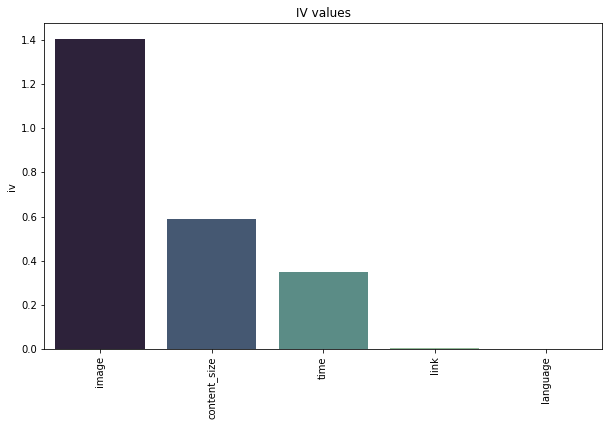

In [7]:
SRH_ar.draw_iv(SRH_feats, SRH_iv)

## Weight of evidence analysis

In [8]:
# calculating information values
(SRH_content_size_iv_df, SRH_content_size_iv_value) = SRH_iv.calculate_iv(SRH_feats[0])
(SRH_image_iv_df, SRH_image_iv_value) = SRH_iv.calculate_iv(SRH_feats[1])
(SRH_link_iv_df, SRH_link_iv_value) = SRH_iv.calculate_iv(SRH_feats[2])
(SRH_language_iv_df, SRH_language_iv_value) = SRH_iv.calculate_iv(SRH_feats[3])
(SRH_time_iv_df, SRH_time_iv_value) = SRH_iv.calculate_iv(SRH_feats[4])

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# rename columns and add new ones
SRH_content_size_iv_df = SRH_content_size_iv_df.rename(columns={"content_size": "contents"})
SRH_content_size_iv_df["features"] = "content_size"

SRH_image_iv_df = SRH_image_iv_df.rename(columns={"image": "contents"})
SRH_image_iv_df["features"] = "image"

SRH_link_iv_df = SRH_link_iv_df.rename(columns={"link": "contents"})
SRH_link_iv_df["features"] = "link"

SRH_language_iv_df = SRH_language_iv_df.rename(columns={"language": "contents"})
SRH_language_iv_df["features"] = "language"

SRH_time_iv_df = SRH_time_iv_df.rename(columns={"time": "contents"})
SRH_time_iv_df["features"] = "time"

SRH_time_iv_df

,contents,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv,features
0,Early Morning,8,4,4,0.235294,0.061538,0.173756,1.341174,0.233037,time
1,Eve,23,3,20,0.176471,0.307692,-0.131222,-0.555946,0.072952,time
2,Late Night,8,2,6,0.117647,0.092308,0.025339,0.242562,0.006146,time
3,Morning,20,3,17,0.176471,0.261538,-0.085068,-0.393427,0.033468,time
4,Night,5,1,4,0.058824,0.061538,-0.002715,-0.045120,0.000122,time
5,Noon,18,4,14,0.235294,0.215385,0.019910,0.088411,0.001760,time


In [10]:
# concatinating the dataframes
SRH_frames = [SRH_content_size_iv_df, SRH_image_iv_df, SRH_link_iv_df, SRH_language_iv_df, SRH_time_iv_df]
SRH_woe_df = pd.concat(SRH_frames)
SRH_woe_df = SRH_woe_df[["features", "contents", "woe"]]
SRH_woe_df = SRH_woe_df[SRH_woe_df["contents"] != ""]
SRH_woe_df = SRH_woe_df.set_index("contents")

In [11]:
SRH_woe_df.to_csv('../data/SRH_woe_data.csv')
SRH_woe_df

,features,woe
contents,,
long,content_size,0.935709
medium,content_size,-0.856051
short,content_size,-0.408026
has_image,image,-2.214174
no_image,image,0.712565
has_link,link,0.041891
no_link,link,-0.093911
am,language,0.000000
en,language,0.047253


/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


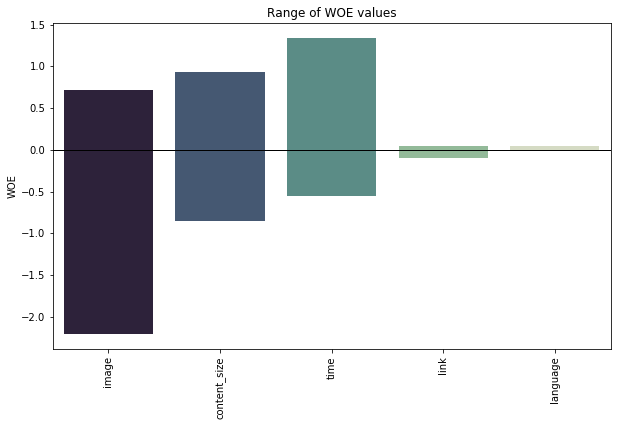

In [12]:
SRH_ar.draw_woe_extremes(SRH_feats, SRH_iv)

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


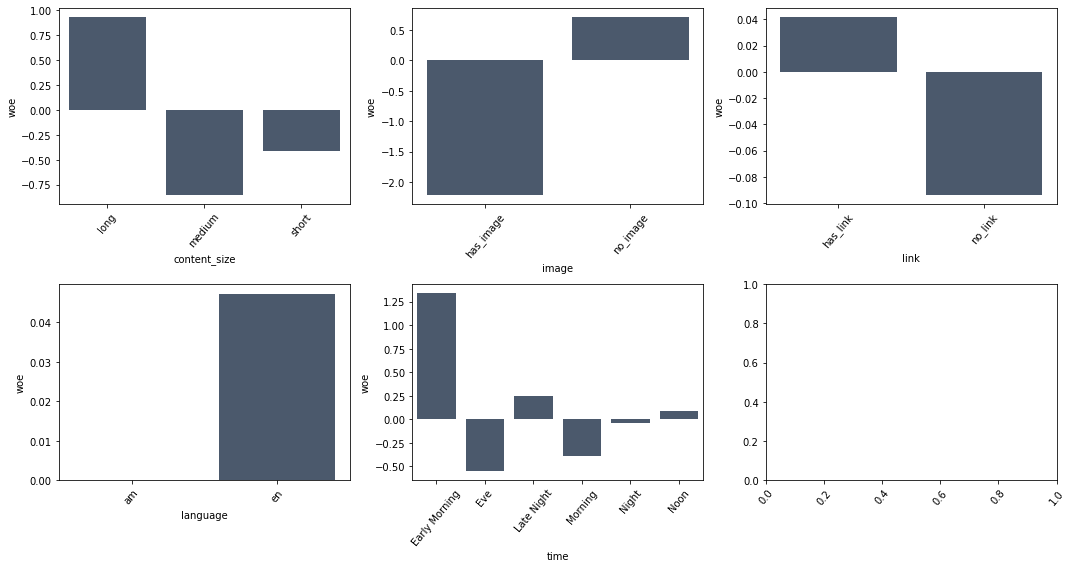

In [13]:
f_draw = ["content_size", "image", "link", "language", "time"]
SRH_feats_draw = [v for k, v in SRH_feats_dict.items() if k in f_draw]
SRH_ar.draw_woe_multiplot(SRH_feats_draw, SRH_iv)

## Abortion

### IV analysis

In [31]:
# extract sub topics
SRH_abortion_sub_topics = ["abortion", "ፅንስ ማስወረድ"]

SRH_abortion_df = df[df["text"].apply(lambda txt: extract_sub_topics(txt, SRH_abortion_sub_topics))]
SRH_abortion_df.shape

(11, 7)

In [33]:
SRH_abortion_feats_dict = {}
for col in [c for c in SRH_abortion_df.columns if (c != "label" and c != "text")]:
    SRH_abortion_feats_dict[col] = CategoricalFeature(SRH_abortion_df, col)
SRH_abortion_feats = list(SRH_abortion_feats_dict.values())

SRH_abortion_iv = IV()
SRH_abortion_ss = StatsSignificance()
SRH_abortion_ar = AttributeRelevance()

SRH_abortion_df = SRH_ar.analyze(SRH_abortion_feats, SRH_abortion_iv, interpretation=True)
SRH_abortion_df.to_csv('../data/SRH_aborition_iv_data.csv')
SRH_abortion_df

,iv,iv_interpretation
content_size,0.0,useless
image,0.0,useless
link,0.0,useless
language,0.0,useless
time,0.0,useless


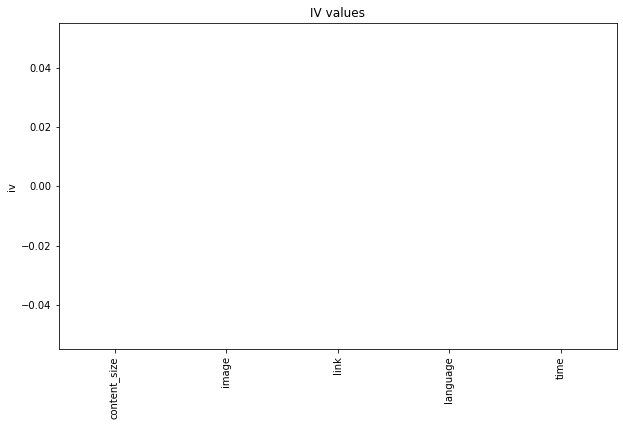

In [37]:
SRH_abortion_ar.draw_iv(SRH_abortion_feats, SRH_abortion_iv)

### WOE analysis

In [ ]:
# calculating information values
(SRH_content_size_iv_df, SRH_content_size_iv_value) = SRH_iv.calculate_iv(SRH_feats[0])
(SRH_image_iv_df, SRH_image_iv_value) = SRH_iv.calculate_iv(SRH_feats[1])
(SRH_link_iv_df, SRH_link_iv_value) = SRH_iv.calculate_iv(SRH_feats[2])
(SRH_language_iv_df, SRH_language_iv_value) = SRH_iv.calculate_iv(SRH_feats[3])
(SRH_time_iv_df, SRH_time_iv_value) = SRH_iv.calculate_iv(SRH_feats[4])

# rename columns and add new ones
SRH_content_size_iv_df = SRH_content_size_iv_df.rename(columns={"content_size": "contents"})
SRH_content_size_iv_df["features"] = "content_size"

SRH_image_iv_df = SRH_image_iv_df.rename(columns={"image": "contents"})
SRH_image_iv_df["features"] = "image"

SRH_link_iv_df = SRH_link_iv_df.rename(columns={"link": "contents"})
SRH_link_iv_df["features"] = "link"

SRH_language_iv_df = SRH_language_iv_df.rename(columns={"language": "contents"})
SRH_language_iv_df["features"] = "language"

SRH_time_iv_df = SRH_time_iv_df.rename(columns={"time": "contents"})
SRH_time_iv_df["features"] = "time"

# concatinating the dataframes
SRH_frames = [SRH_content_size_iv_df, SRH_image_iv_df, SRH_link_iv_df, SRH_language_iv_df, SRH_time_iv_df]
SRH_woe_df = pd.concat(SRH_frames)
SRH_woe_df = SRH_woe_df[["features", "contents", "woe"]]
SRH_woe_df = SRH_woe_df[SRH_woe_df["contents"] != ""]
SRH_woe_df = SRH_woe_df.set_index("contents")

SRH_woe_df.to_csv('../data/SRH_woe_data.csv')
SRH_woe_df

In [ ]:
SRH_ar.draw_woe_extremes(SRH_feats, SRH_iv)

# Part - 3: GBV WOE and IV Analysis

## GBV dataframe

In [14]:
# extract SRH dataframe
GBV_sub_topics =  ["gender-based violence", "rape", "sexual violence", "forced marriage", 
                   "Sexual Abuse", "Emotional Violence", "Physical violence",
                   "በጾታ ላይ የተመሠረተ ጥቃት", "አስገድዶ መድፈር", "ወሲባዊ ጥቃት", "የግዳጅ ጋብቻ",
                   "ወሲባዊ በደል", "ስሜታዊ ጥቃት", "የአካል ብጥብጥ"]

GBV_df = df[df["text"].apply(lambda txt: extract_sub_topics(txt, GBV_sub_topics))]
GBV_df.shape

(37, 7)

## Convert features to bins

In [15]:
GBV_feats_dict = {}

for col in [c for c in GBV_df.columns if (c != "label" and c != "text")]:
    GBV_feats_dict[col] = CategoricalFeature(GBV_df, col)

GBV_feats = list(GBV_feats_dict.values())

## Information value analysis

In [16]:
GBV_iv = IV()
GBV_ss = StatsSignificance()
GBV_ar = AttributeRelevance()

In [17]:
GBV_iv_df = GBV_ar.analyze(GBV_feats, GBV_iv, interpretation=True)
GBV_iv_df.to_csv('../data/GBV_iv_data.csv')
GBV_iv_df

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,iv_interpretation
image,1.396096,suspicious
link,0.867580,suspicious
time,0.389345,strong
language,0.018230,useless
content_size,0.010530,useless


/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


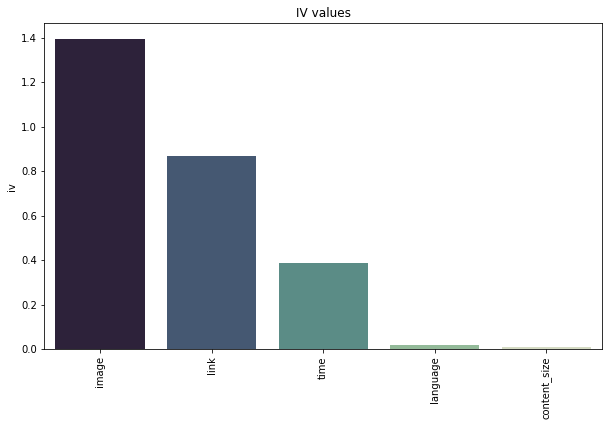

In [18]:
GBV_ar.draw_iv(GBV_feats, GBV_iv)

## Weight of evidence analysis

In [19]:
# calculating information values
(GBV_content_size_iv_df, GBV_content_size_iv_value) = GBV_iv.calculate_iv(GBV_feats[0])
(GBV_image_iv_df, GBV_image_iv_value) = GBV_iv.calculate_iv(GBV_feats[1])
(GBV_link_iv_df, GBV_link_iv_value) = GBV_iv.calculate_iv(GBV_feats[2])
(GBV_language_iv_df, GBV_language_iv_value) = GBV_iv.calculate_iv(GBV_feats[3])
(GBV_time_iv_df, GBV_time_iv_value) = GBV_iv.calculate_iv(GBV_feats[4])

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
# rename columns and add new ones
GBV_content_size_iv_df = GBV_content_size_iv_df.rename(columns={"content_size": "contents"})
GBV_content_size_iv_df["features"] = "content_size"

GBV_image_iv_df = GBV_image_iv_df.rename(columns={"image": "contents"})
GBV_image_iv_df["features"] = "image"

GBV_link_iv_df = GBV_link_iv_df.rename(columns={"link": "contents"})
GBV_link_iv_df["features"] = "link"

GBV_language_iv_df = GBV_language_iv_df.rename(columns={"language": "contents"})
GBV_language_iv_df["features"] = "language"

GBV_time_iv_df = GBV_time_iv_df.rename(columns={"time": "contents"})
GBV_time_iv_df["features"] = "time"

# concatinating the dataframes
GBV_frames = [GBV_content_size_iv_df, GBV_image_iv_df, GBV_link_iv_df, GBV_language_iv_df, GBV_time_iv_df]
GBV_woe_df = pd.concat(GBV_frames)
GBV_woe_df = GBV_woe_df[["features", "contents", "woe"]]
GBV_woe_df = GBV_woe_df[GBV_woe_df["contents"] != ""]
GBV_woe_df = GBV_woe_df.set_index("contents")
GBV_woe_df.to_csv('../data/GBV_woe_data.csv')
GBV_woe_df

,features,woe
contents,,
long,content_size,-0.042560
medium,content_size,-0.063179
short,content_size,0.208755
has_image,image,-2.068512
no_image,image,0.758801
has_link,link,0.678758
no_link,link,-1.375365
am,language,0.000000
en,language,0.139762


/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


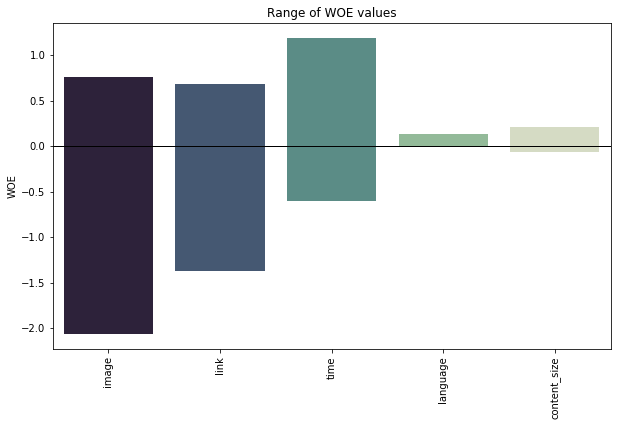

In [21]:
GBV_ar.draw_woe_extremes(GBV_feats, GBV_iv)

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


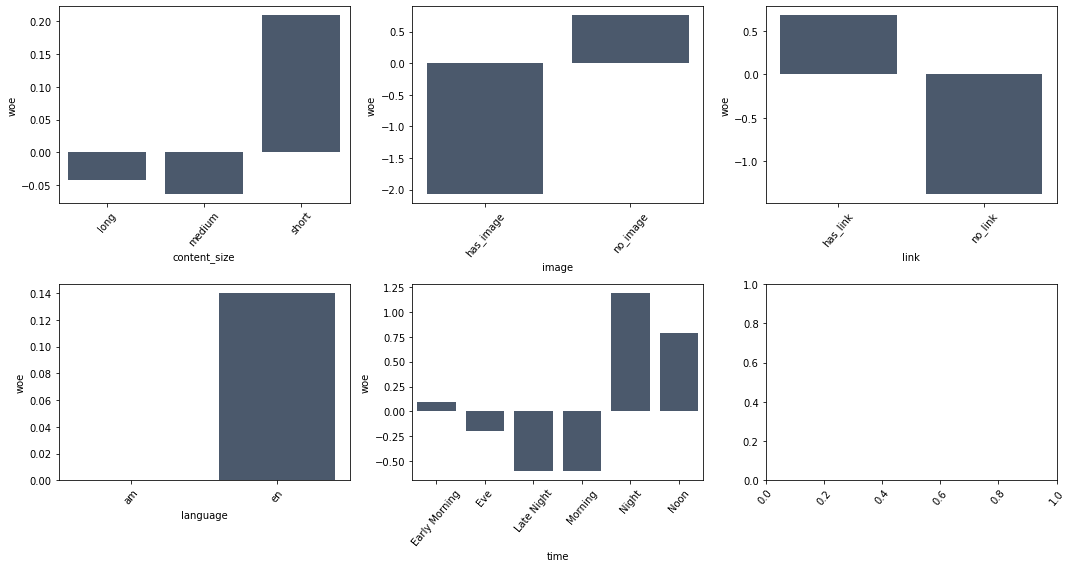

In [22]:
f_draw = ["content_size", "image", "link", "language", "time"]
GBV_feats_draw = [v for k, v in GBV_feats_dict.items() if k in f_draw]
GBV_ar.draw_woe_multiplot(GBV_feats_draw, GBV_iv)